## Загрузка библиотек

In [1]:
pip install w3lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

# Доп. библиотеки
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import copy
from tqdm import tqdm
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download("stopwords")

# Еще библиотеки
from IPython.display import HTML, IFrame
from w3lib.html import remove_tags
import spacy
from tqdm import tqdm_notebook
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive/')
main_path = "/content/drive/MyDrive/Университет/Курсовые/Курсовая. Классификация текстов"
os.chdir(main_path)

Mounted at /content/drive/


## EDA и предобработка данных

### Первоначальный обзор данных

In [4]:
data = pd.read_csv("data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
# Смотрим на размерность нашего датасета
data.shape

(50000, 2)

In [7]:
# Смотрим на распределение классов целевого значения 
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [8]:
# Проверяем пропущенные значения
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [9]:
# Проверим, если повторяющиеся значения
(data
 .duplicated(keep='last')
 .sum())

418

In [10]:
# Удаление дубликатов
data.drop_duplicates(keep='first', inplace=True)

### Предобработка

In [16]:
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
           "'cause": "because", "could've": "could have", "couldn't": "could not", 
           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
           "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
           "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
           "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
           "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
           "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
           "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
           "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
           "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
           "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
           "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
           "she's": "she is", "should've": "should have", "shouldn't": "should not", 
           "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
           "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
           "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
           "here's": "here is","they'd": "they would", "they'd've": "they would have", 
           "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
           "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
           "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
           "we're": "we are", "we've": "we have", "weren't": "were not", 
           "what'll": "what will", "what'll've": "what will have","what're": "what are",  
           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", 
           "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
           "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
           "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
           "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
           "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
           "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
           "you're": "you are", "you've": "you have" }

#Spacy lemmatization
spacy_model = spacy.load("en_core_web_sm", disable = ['parser','ner'])

In [13]:
t = "you'reu"
mapping.get(t,t)

"you'reu"

In [30]:
def preprocess_text(text):
  text = remove_tags(text)
  text = text.lower()
  text = text = ' '.join([mapping.get(t,t) for t in text.split(" ")]) #Заменяем разгвоворные обороты речи
  text = re.sub("[^a-z]", " ", text)
  text = re.sub(r"\s+", ' ', text)
  doc = spacy_model(text)
  text = " ".join([token.lemma_ for token in doc if not token.is_stop])
  return text

In [31]:
HTML(preprocess_text(data.review.iloc[1]))

In [32]:
data["clean_review"] = data.review.apply(preprocess_text)
data.to_csv("./data/dataset_clean_4", index = False)

### Последующий обзор данных

In [5]:
cdata = pd.read_csv("./data/dataset_clean_4")
cdata.sentiment = cdata.sentiment.map({"positive": 1,
                                       "negative": 0})
cdata = cdata.iloc[:, [0, 2, 1]]
cdata.head()

,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,reviewer mention watch oz episode hook right e...,1
1,A wonderful little production. <br /><br />The...,wonderful little production film technique una...,1
2,I thought this was a wonderful way to spend ti...,think wonderful way spend time hot summer week...,1
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei s love time money visually stunn...,1


In [36]:
HTML(cdata.review.iloc[1])

In [37]:
HTML(cdata.clean_review.iloc[1])

In [38]:
cdata.drop("review", axis=1, inplace=True)

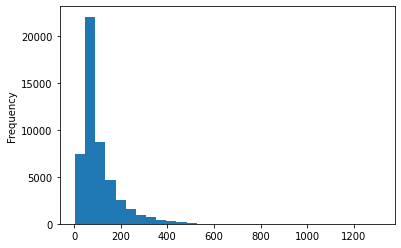

In [40]:
cdata.clean_review.str.split().apply(lambda x: len(x)).plot.hist(bins=30)

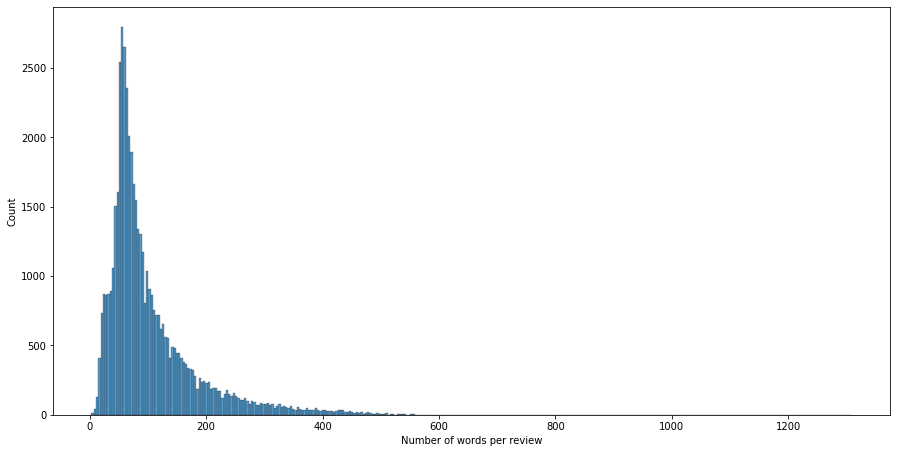

In [46]:
# Распределение количества слов в отзыве
scale = 0.5
fig, ax = plt.subplots(figsize=(30*scale,15*scale))
sns.histplot(cdata.clean_review.str.split().apply(lambda x: len(x)).tolist(), ax=ax)
ax.set_xlabel('Number of words per review')
plt.show()

In [48]:
rev_len = cdata.clean_review.str.split().apply(lambda x: len(x))
rev_len.describe()

count    49582.000000
mean       104.595519
std         80.630538
min          3.000000
25%         55.000000
50%         77.000000
75%        127.000000
max       1310.000000
Name: clean_review, dtype: float64

In [49]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

In [51]:
pos_data = cdata[cdata.sentiment==1].clean_review
neg_data = cdata[cdata.sentiment==0].clean_review

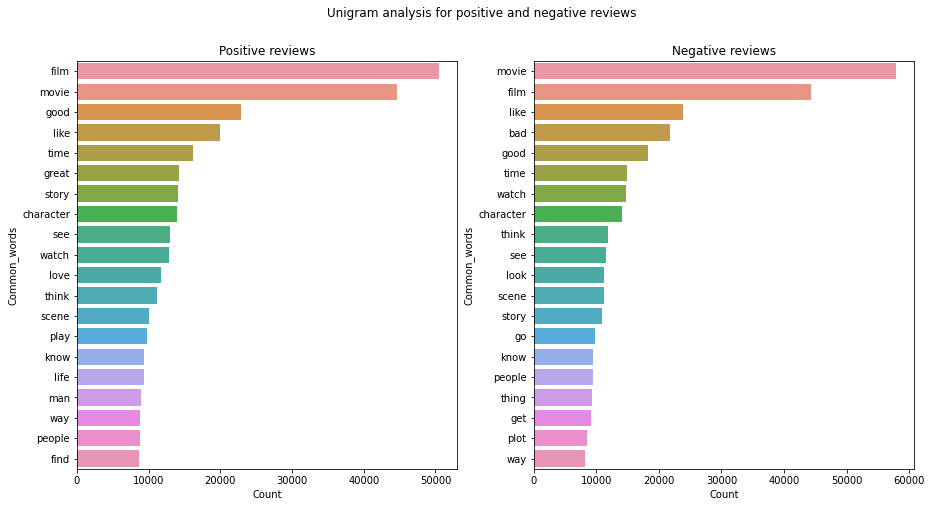

In [52]:
#unigrams
scale = 0.5
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30*scale,15*scale))
uni_positive = get_ngrams(pos_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(neg_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

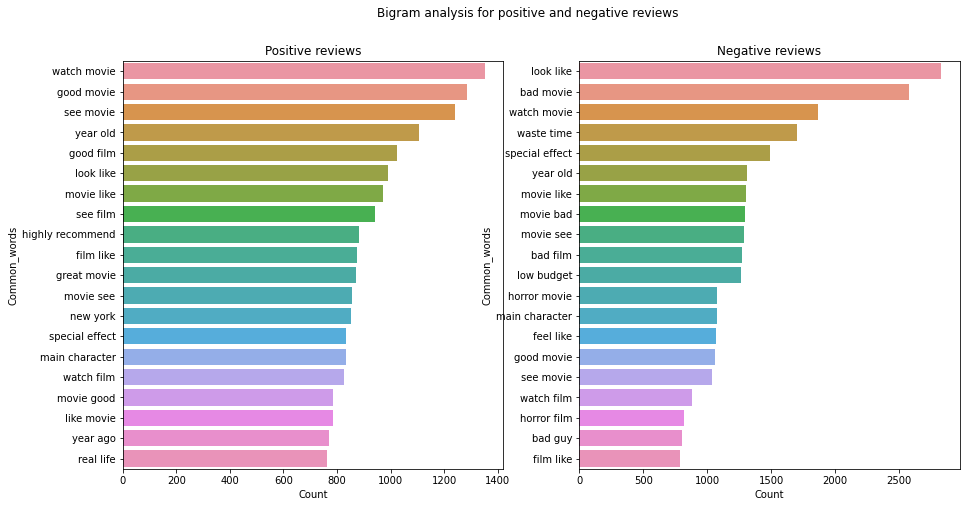

In [53]:
# bigrams
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30*scale,15*scale))
bi_positive = get_ngrams(pos_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(neg_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

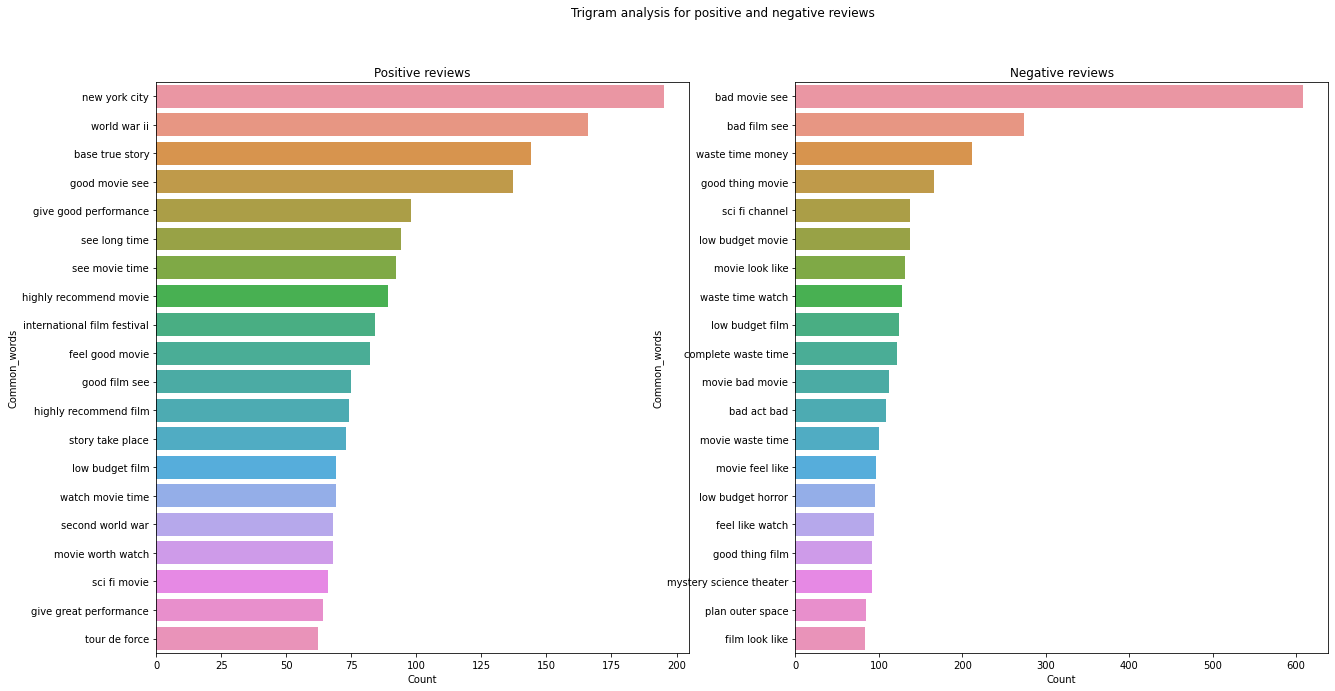

In [58]:
# Trigrams
scale = 0.7
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30*scale,15*scale))
tri_positive = get_ngrams(pos_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(neg_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

## ML

In [6]:
#splitting into train and test
train, test= train_test_split(cdata, test_size=0.3, random_state=42)
Xtrain, ytrain = train['clean_review'], train['sentiment']
Xtest, ytest = test['clean_review'], test['sentiment']

In [6]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

In [63]:
res = pd.DataFrame({"Model": [], "Accuracy": []})
res

,Model,Accuracy


### Logistic Regression

In [53]:
lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))


Logistic Regression Accuracy : 88.97%


In [64]:
res = res.append({"Model": "Log Regression", 
                  "Accuracy": "{:.2f}%".format(100*s1)}, ignore_index=True)

### Naive Bayes

In [56]:
mnb= MultinomialNB()
mnb.fit(Xtrain_count,ytrain)
p2=mnb.predict(Xtest_count)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))

Multinomial Naive Bayes Classifier Accuracy : 85.28%


In [65]:
res = res.append({"Model": "Naive Bayes", 
                  "Accuracy": "{:.2f}%".format(100*s2)}, ignore_index=True)

In [69]:
res.style.hide_index()

Model,Accuracy
Log Regression,88.97%
Naive Bayes,85.28%


## Deep learning

In [7]:
Xtrain_len = Xtrain.str.split().apply(lambda x: len(x))
Xtrain_len.describe()

count    34707.000000
mean       104.692252
std         80.691193
min          3.000000
25%         55.000000
50%         77.000000
75%        127.000000
max       1007.000000
Name: clean_review, dtype: float64

In [8]:
max_seq_len = int(Xtrain_len.mean() + 2 * Xtrain_len.std())
max_seq_len

266

In [72]:
perc_covered = np.sum(Xtrain_len < max_seq_len) / len(Xtrain_len)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.49 % of data


In [9]:
class Vocab:
  def __init__(self, data: list, max_seq_len):
    st = set()
    self.max_seq_len = max_seq_len
    for x in data:
      rev = nltk.word_tokenize(x)
      st.update(rev)
    self.unk_token = '<UNK>'
    self.pad_token = '<PAD>'
    #unique_words = [self.pad_token, self.unk_token] + sorted(list(st - set(stopwords.words('english'))))
    unique_words = [self.pad_token, self.unk_token] + sorted(list(st))
    word_ind = list(np.arange(len(unique_words)))
    self.idx_to_token = dict(zip(word_ind, unique_words))
    self.token_to_idx = dict(zip(unique_words, word_ind))
    self.vocab_len = len(unique_words)


class ReviewDataset(Dataset):
  def __init__(self, X, y, vocab: Vocab):
    self.X = X
    self.y = y
    self.vocab = vocab

  def get_idx(self, review):
    review = nltk.word_tokenize(review)
    pad_idx = self.vocab.token_to_idx[self.vocab.pad_token]
    unk_idx = self.vocab.token_to_idx[self.vocab.unk_token]
    idx = [pad_idx] * self.vocab.max_seq_len
    n = min(len(review), self.vocab.max_seq_len)
    for i in range(n):
      idx[i] = self.vocab.token_to_idx.get(review[i], unk_idx)

    
    return torch.tensor(idx, dtype=torch.int64)


  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    #return self.X.iloc[idx], self.get_idx(self.X.iloc[idx]), self.y.iloc[idx]
    return self.get_idx(self.X.iloc[idx]), self.y.iloc[idx]

In [36]:
vocab = Vocab(Xtrain.tolist(), max_seq_len)
review_train = ReviewDataset(Xtrain, ytrain, vocab)
review_test = ReviewDataset(Xtest, ytest, vocab)

batch_size = 32
train_iter = DataLoader(review_train, batch_size, shuffle=True)
test_iter = DataLoader(review_test, batch_size, shuffle=False)

In [74]:
vocab.vocab_len

73569

In [11]:
# v2

def number_of_correct_ans(y_hat, y):
  # Считаем кол-во верных ответов (работает для ответов - векторов)
  y_hat = y_hat.argmax(axis=1)
  correct_mask = y_hat == y
  return correct_mask.sum()


def evaluate_accuracy(net, test_iter):

  # Выставляем режим оценки модели
  net.eval()

  total_samples = len(test_iter.dataset) #Общее кол-во элементво в выборке
  correct_ans = 0

  with torch.no_grad():
    for X, y in test_iter:
      X, y = X.to(device), y.to(device)

      y_hat = net(X)
      correct_ans += number_of_correct_ans(y_hat, y)

  return correct_ans / total_samples


def train_epoch(net, train_iter, loss, updater, clip_value):

  # Выставляем режим обучения модели
  net.train()

  total_samples = len(train_iter.dataset)
  correct_samples = 0
  total_loss = 0

  for X, y in train_iter:
    X, y = X.to(device), y.to(device)

    y_hat = net(X)
    l = loss(y_hat, y)

    updater.zero_grad()
    l.backward()
    if clip_value:
      torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    updater.step()

    total_loss += l
    correct_samples += number_of_correct_ans(y_hat, y)

  return total_loss / total_samples, correct_samples / total_samples


class Model_metrics:
  def __init__(self):
    self.train_loss = []
    self.train_accuracy = []
    self.test_accuracy = []

  def add(self, train_loss, train_accuracy, test_accuracy):
      self.train_loss.append(train_loss.cpu().item())
      self.train_accuracy.append(train_accuracy.cpu().item())
      self.test_accuracy.append(test_accuracy.cpu().item())

  def plot(self):
      plt.rcParams.update({'font.size': 12})
      fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
      epochs = np.arange(len(self.train_loss))

      # График функции потерь
      ax[0].plot(epochs, self.train_loss, label="train loss")
      ax[0].set_xticks(epochs)
      ax[0].grid()
      ax[0].legend()

      # График точности на обучении и тесте
      ax[1].plot(epochs, self.train_accuracy, label="train accuracy")
      ax[1].plot(epochs, self.test_accuracy, label="test accuracy")
      ax[1].set_xticks(epochs)
      ax[1].grid()
      ax[1].legend()

      plt.show()


  def return_dict(self):
    res = {
        "train_loss": self.train_loss,
        "train_accuracy": self.train_accuracy,
        "test_accuracy": self.test_accuracy
    }
    return res


def saving(net, model_metrics, path):
  state = {"state_dict": net.state_dict()}
  metrics_dict = model_metrics.return_dict()
  state = {**state, **metrics_dict}
  torch.save(state, path)


def train_rnn_model(net, train_iter, test_iter, loss,
                num_epochs, updater, clip_value = None, path=None):

  model_metrics = Model_metrics()
  for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_epoch(net, train_iter, loss, updater, clip_value)
    test_accuracy = evaluate_accuracy(net, test_iter)
    model_metrics.add(train_loss, train_accuracy, test_accuracy)
    print (f': Loss: {train_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')
  model_metrics.plot()
  if path:
    saving(net, model_metrics, path)


### Two layer GRU

In [76]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size  * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.sum(axis=1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 64
rnn_hidden_size = 256
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

num_epochs = 5 

 20%|██        | 1/5 [01:02<04:11, 62.98s/it]

: Loss: 0.0134, Train acc: 0.8229, Test acc: 0.8458


 40%|████      | 2/5 [02:00<02:59, 59.97s/it]

: Loss: 0.0102, Train acc: 0.8766, Test acc: 0.8701


 60%|██████    | 3/5 [02:59<01:59, 59.58s/it]

: Loss: 0.0080, Train acc: 0.9103, Test acc: 0.8761


 80%|████████  | 4/5 [03:57<00:58, 58.72s/it]

: Loss: 0.0061, Train acc: 0.9328, Test acc: 0.8706


100%|██████████| 5/5 [04:55<00:00, 59.08s/it]

: Loss: 0.0045, Train acc: 0.9547, Test acc: 0.8742


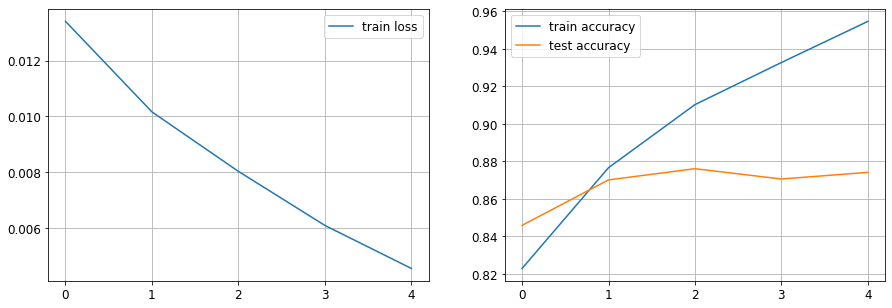

In [78]:
#Обучение сети
path = "./Saved models/GRU_code_2_1.pt"
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value, path)

In [80]:
state = torch.load(path, map_location=device)
net.load_state_dict(state["state_dict"])
acc = evaluate_accuracy(net, test_iter)
print("Точность на тестовом множестве:", "{:.2f}%".format(100*acc))

Точность на тестовом множестве: 87.42%


In [81]:
res = res.append({"Model": "Two layer gru", 
                  "Accuracy": "{:.2f}%".format(100*acc)}, ignore_index=True)

### 3 layer gru

In [90]:
vocab_len = vocab.vocab_len
embedding_size = 64
rnn_hidden_size = 256
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 3)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

path = "./Saved models/GRU_code_2_3.pt"
num_epochs = 10

 10%|█         | 1/10 [01:13<11:00, 73.37s/it]

: Loss: 0.0193, Train acc: 0.7351, Test acc: 0.8337


 20%|██        | 2/10 [02:24<09:35, 71.88s/it]

: Loss: 0.0119, Train acc: 0.8526, Test acc: 0.8614


 30%|███       | 3/10 [03:34<08:17, 71.10s/it]

: Loss: 0.0092, Train acc: 0.8925, Test acc: 0.8684


 40%|████      | 4/10 [04:46<07:08, 71.38s/it]

: Loss: 0.0072, Train acc: 0.9189, Test acc: 0.8749


 50%|█████     | 5/10 [05:56<05:54, 70.92s/it]

: Loss: 0.0054, Train acc: 0.9433, Test acc: 0.8424


 60%|██████    | 6/10 [07:06<04:43, 70.77s/it]

: Loss: 0.0037, Train acc: 0.9646, Test acc: 0.8700


 70%|███████   | 7/10 [08:18<03:33, 71.17s/it]

: Loss: 0.0028, Train acc: 0.9770, Test acc: 0.8643


 80%|████████  | 8/10 [09:29<02:21, 70.98s/it]

: Loss: 0.0021, Train acc: 0.9845, Test acc: 0.8602


 90%|█████████ | 9/10 [10:46<01:12, 72.99s/it]

: Loss: 0.0021, Train acc: 0.9874, Test acc: 0.8655


100%|██████████| 10/10 [12:04<00:00, 72.45s/it]

: Loss: 0.0015, Train acc: 0.9893, Test acc: 0.8585


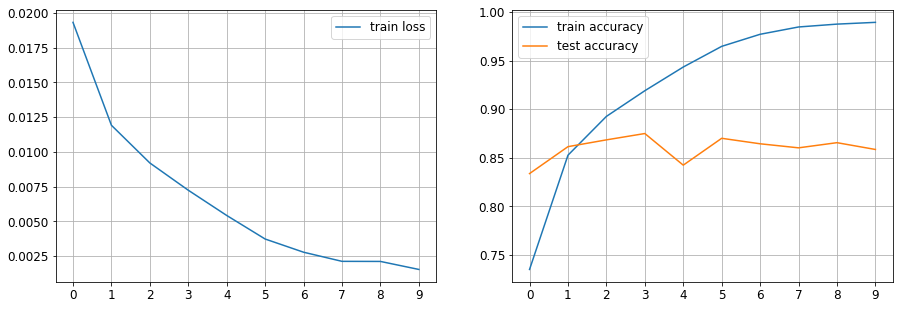

In [91]:
#Обучение сети
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value, path)

### Concat GRU

In [93]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size  * (1 + self.bidir) * self.seq_len, 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.reshape(batch_size, self.hidden_dim * self.seq_len)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 64
rnn_hidden_size = 256
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

num_epochs = 5 

 20%|██        | 1/5 [00:57<03:50, 57.61s/it]

: Loss: 0.0154, Train acc: 0.7631, Test acc: 0.8376


 40%|████      | 2/5 [01:55<02:53, 57.76s/it]

: Loss: 0.0101, Train acc: 0.8694, Test acc: 0.8633


 60%|██████    | 3/5 [02:54<01:56, 58.30s/it]

: Loss: 0.0073, Train acc: 0.9071, Test acc: 0.8584


 80%|████████  | 4/5 [03:51<00:58, 58.00s/it]

: Loss: 0.0050, Train acc: 0.9403, Test acc: 0.8640


100%|██████████| 5/5 [04:50<00:00, 58.03s/it]

: Loss: 0.0031, Train acc: 0.9632, Test acc: 0.8606


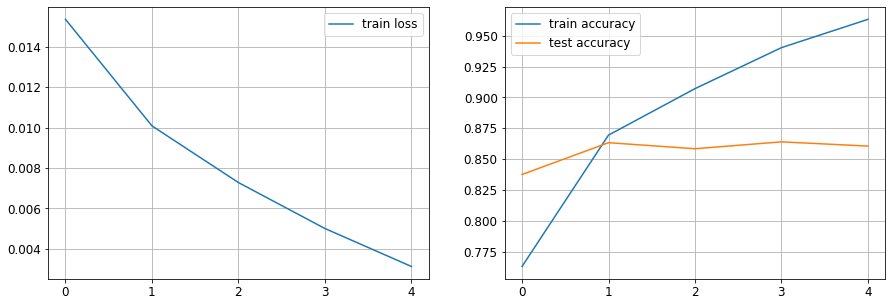

In [94]:
#Обучение сети
path = "./Saved models/GRU_code_2_concat.pt"
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value, path)

## Pre-trained deep learning

In [16]:
words_path = "../../ТОБД/2 семестр/Задание 7/embeddings/glove.6B.50d.txt"
with open(words_path) as f:
    lines = f.readlines()

In [40]:
words = set()
emb_dim = 50
embeddings = np.empty((len(lines), emb_dim))
word2idx = dict()
for idx, line in enumerate(lines):
  line = line.split()
  word = line[0]
  words.add(word)
  embeddings[idx] = np.array(line[1:]).astype(float)
  word2idx[word] = idx

len(words)

400000

In [42]:
vocab_emb = np.empty((vocab.vocab_len, emb_dim))
missed_words = 0
for idx, word in enumerate(vocab.idx_to_token.values()):
  if word in words:
    word_idx = word2idx[word]
    vocab_emb[idx] = embeddings[word_idx]
  else:
    vocab_emb[idx] = np.random.normal(scale=0.6, size=(emb_dim, ))
    missed_words += 1

missed_words

### 2 layer GRU with pretrained word embeddings

In [74]:
class GRU_model(nn.Module):
  def __init__(self, vocab_len, embedding_size, rnn_hidden_size,
               num_classes, seq_len, num_layers=1, bidir=False, pr_embs=None):
    super().__init__()
    self.hidden_dim = rnn_hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.bidir = bidir
    if pr_embs.any():
      self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(pr_embs).float(),
                                                          freeze=False, padding_idx=0)
    else:
      self.embedding = nn.Embedding(vocab_len, embedding_size, padding_idx=0)
    self.rnn = nn.GRU(embedding_size, rnn_hidden_size,
                      num_layers = num_layers, batch_first=True, bidirectional = bidir)
    self.classifier = nn.Sequential(nn.Linear(rnn_hidden_size  * (1 + self.bidir), 
                                              rnn_hidden_size),nn.ReLU(), nn.Dropout(0.5),
                                     nn.Linear(rnn_hidden_size, num_classes))
    self.dropout = nn.Dropout(0.5)
    
  def forward(self, X):
    #h0 = torch.zeros((1 + self.bidir) * numm, X.size(0), self.hidden_dim).to(device)
    batch_size = X.shape[0]
    
    emb = self.embedding(X) # batch x seq x emb
    out, hidden = self.rnn(emb)
    out = out.sum(axis=1)
    out = self.dropout(out) # batch x rnn_hidden
    out = self.classifier(out) # batch x num_classes
    return out


vocab_len = vocab.vocab_len
embedding_size = 50
rnn_hidden_size = 256
num_classes = 2
seq_len = vocab.max_seq_len
net = GRU_model(vocab_len, embedding_size, rnn_hidden_size,
                num_classes, seq_len, num_layers = 2, pr_embs=vocab_emb)
net.to(device)

loss = nn.CrossEntropyLoss()  
lr = 0.001
updater = optim.Adam(net.parameters(), lr=lr)
clip_value = 5

num_epochs = 4

 25%|██▌       | 1/4 [00:57<02:53, 57.80s/it]

: Loss: 0.0205, Train acc: 0.7605, Test acc: 0.8368


 50%|█████     | 2/4 [01:53<01:53, 56.59s/it]

: Loss: 0.0111, Train acc: 0.8759, Test acc: 0.8840


 75%|███████▌  | 3/4 [02:49<00:56, 56.39s/it]

: Loss: 0.0086, Train acc: 0.9114, Test acc: 0.8709


100%|██████████| 4/4 [03:46<00:00, 56.72s/it]

: Loss: 0.0065, Train acc: 0.9389, Test acc: 0.8756


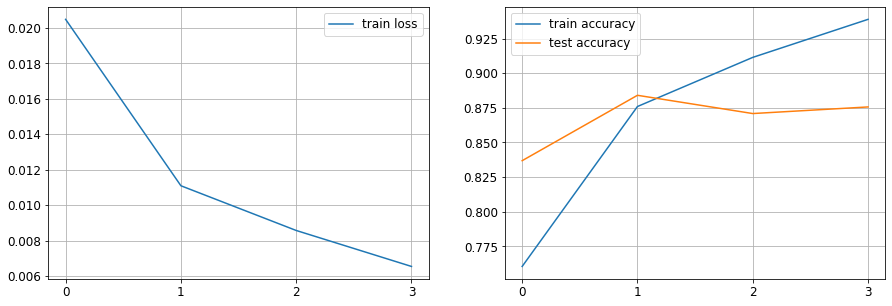

In [75]:
#Обучение сети
path = "./Saved models/GRU_code_2_pre_2.pt"
train_rnn_model(net, train_iter, test_iter, loss, num_epochs, updater, clip_value, path)

In [76]:
state = torch.load(path, map_location=device)
net.load_state_dict(state["state_dict"])
acc = evaluate_accuracy(net, test_iter)
print("Точность на тестовом множестве:", "{:.2f}%".format(100*acc))

Точность на тестовом множестве: 87.56%
